## Linear Regression Using SVRGModule on YearPredictionMSD Dataset

In this notebook, a linear regression model will be fit on YearPredictionMSD dataset, which contains predictions of the release year of a song based on its audio features. The dataset has 90 features and over 400,000 samples. The dataset is downsampled to 5,000 in this experiment.

In [1]:
import os
import json
import sys
import tempfile

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import mxnet as mx
from mxnet.contrib.svrg_optimization.svrg_module import SVRGModule
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.datasets import load_svmlight_file

sys.path.insert(0, "../linear_regression")
from data_reader import get_year_prediction_data

%matplotlib inline

### Read Data
The first step is to get the training features and labels and normalize the data. In this example, we will use 5000 data samples.  

In [2]:
feature_dim, train_features, train_labels = get_year_prediction_data()

Extracting data...
Reading data from disk...


In [3]:
train_features = train_features[-5000:]
train_labels   = train_labels[-5000:]

### Create Linear Regression Network

In [4]:
def create_lin_reg_network(batch_size=100):
    train_iter = mx.io.NDArrayIter(train_features, train_labels, batch_size=batch_size, shuffle=True,
                               data_name='data', label_name='label')
    data = mx.sym.Variable("data")
    label = mx.sym.Variable("label")
    weight = mx.sym.Variable("fc_weight", shape=(1, 90))
    net = mx.sym.dot(data, weight.transpose())
    bias = mx.sym.Variable("fc_bias", shape=(1,), wd_mult=0.0, lr_mult=10.0)
    net = mx.sym.broadcast_plus(net, bias)
    net = mx.sym.LinearRegressionOutput(data=net, label=label)
    
    return train_iter, net

### SVRGModule with SVRG Optimization
In this example, we will use intermediate level API for SVRGModule and the dump mse per epoch to JSON file for plotting graphs.

In [5]:
def train_svrg_lin_reg(num_epoch=100, batch_size=100, update_freq=2, output='svrg_lr.json', 
                       optimizer_params=None):

    di, net = create_lin_reg_network(batch_size=batch_size)
    
    #Create a SVRGModule
    mod = SVRGModule(symbol=net, context=mx.cpu(0), data_names=['data'], label_names=['label'], update_freq=update_freq)
    mod.bind(data_shapes=di.provide_data, label_shapes=di.provide_label)
    mod.init_params(initializer=mx.init.Zero(), allow_missing=False, force_init=False, allow_extra=False)
    mod.init_optimizer(kvstore='local', optimizer='sgd', optimizer_params=optimizer_params)
    metrics = mx.metric.create("mse")
    
    results = {}
    for e in range(num_epoch):
        results[e] = {}
        metrics.reset()
        if e % mod.update_freq == 0:
            mod.update_full_grads(di)
        di.reset()
        for batch in di:
            mod.forward_backward(data_batch=batch)
            mod.update()
            mod.update_metric(metrics, batch.label)
        results[e]["mse"] = metrics.get()[1]
   
    f = open(output, 'w+')
    f.write(json.dumps(results, indent=4, sort_keys=True))
    f.close()


### Module with SGD Optimization 

In [6]:
def train_sgd_lin_reg(num_epoch=100, batch_size=100, update_freq=2, output='sgd_lr.json', 
                       optimizer_params=None):
    
    di, net = create_lin_reg_network(batch_size=batch_size)
    
    #Create a standard module
    mod = mx.mod.Module(symbol=net, context=mx.cpu(0), data_names=['data'], label_names=['label'])
    mod.bind(data_shapes=di.provide_data, label_shapes=di.provide_label)
    mod.init_params(initializer=mx.init.Zero(), allow_missing=False, force_init=False, allow_extra=False)
    mod.init_optimizer(kvstore='local', optimizer='sgd', optimizer_params=optimizer_params)
    metrics = mx.metric.create("mse")
    
    results = {}
    for e in range(num_epoch):
        results[e] = {}
        metrics.reset()
        di.reset()
        for batch in di:
            mod.forward_backward(data_batch=batch)
            mod.update()
            mod.update_metric(metrics, batch.label)
        results[e]["mse"] = metrics.get()[1]
    f = open(output, 'w+')
    f.write(json.dumps(results, indent=4, sort_keys=True))
    f.close()
  

## Training Loss over 100 Epochs Using lr_scheduler
When a large learning rate is used with SGD, training loss will drop fast but will oscillates above the minimum and never converges. With a small learning rate, it will eventually reach the minimum after many iterations. A common practice is to use learning rate scheduling by starting with a large learning rate and gradually decreasing it. 

In [7]:
train_svrg_lin_reg(optimizer_params={'lr_scheduler': mx.lr_scheduler.FactorScheduler(step=10, factor=0.99)})
train_sgd_lin_reg(optimizer_params={'lr_scheduler': mx.lr_scheduler.FactorScheduler(step=10, factor=0.99)})

Text(0.5,0,'Epochs')

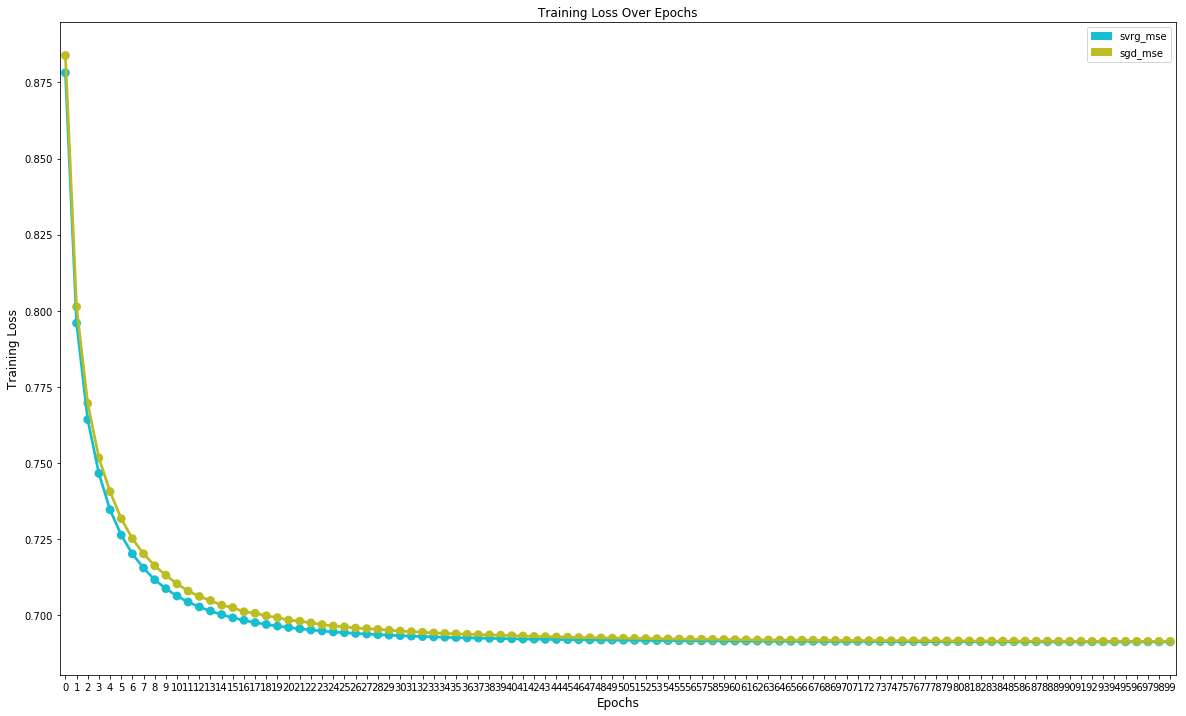

In [10]:
# plot graph
#Plot training loss over Epochs:
color = sns.color_palette()
#Draw Weight Variance Ratio
dataplot3 = {"svrg_mse": [], "sgd_mse": []}
with open('sgd_lr.json') as sgd_data, open('svrg_lr.json') as svrg_data:
    sgd = json.load(sgd_data)
    svrg = json.load(svrg_data)
    for epoch in range(100):
        dataplot3["svrg_mse"].append(svrg[str(epoch)]["mse"])
        dataplot3["sgd_mse"].append(sgd[str(epoch)]["mse"])

x3 = list(range(100))
plt.figure(figsize=(20, 12))
plt.title("Training Loss Over Epochs")
sns.pointplot(x3, dataplot3['svrg_mse'], color=color[9])
sns.pointplot(x3, dataplot3['sgd_mse'], color=color[8])
color_patch1 = mpatches.Patch(color=color[9], label="svrg_mse")
color_patch2 = mpatches.Patch(color=color[8], label="sgd_mse")
plt.legend(handles=[color_patch1, color_patch2])
plt.ylabel('Training Loss', fontsize=12)
plt.xlabel('Epochs', fontsize=12)

## Training Loss Comparison with SGD with fixed learning rates
Choosing learning rate (0.0025, 0.001, 0.005) for SGD and a relatively large learning rate 0.025 for SVRG, we can see SVRG smoothly goes down faster than SGD. Learning rate for SVRG does not need to decay to zero, which means we can start with a larger learning rate.

In [11]:
train_svrg_lin_reg(output="svrg_0.025.json", optimizer_params=(('learning_rate', 0.025),))
train_sgd_lin_reg(output="sgd_0.001.json", optimizer_params=(("learning_rate", 0.001),))
train_sgd_lin_reg(output="sgd_0.0025.json", optimizer_params=(("learning_rate", 0.0025),))
train_sgd_lin_reg(output="sgd_0.005.json", optimizer_params=(("learning_rate", 0.005),))

Text(0.5,0,'Epochs')

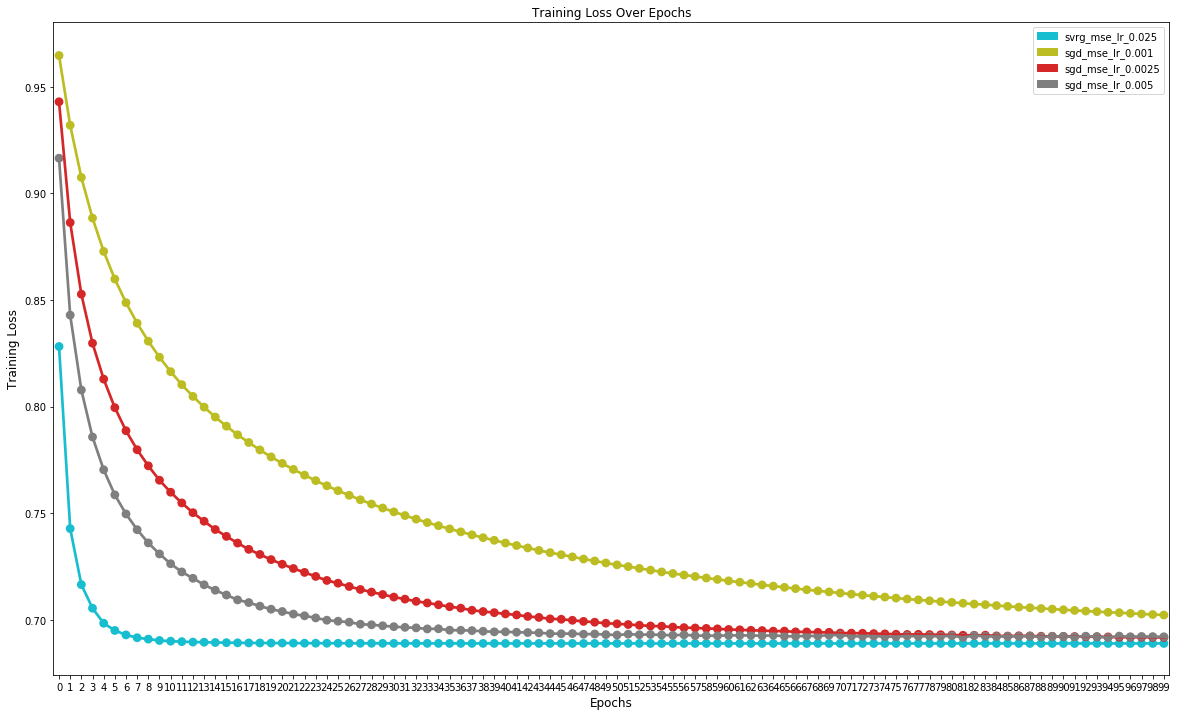

In [13]:
#Plot training loss over Epochs:
color = sns.color_palette()
#Draw Weight Variance Ratio
dataplot3 = {"svrg_mse": [], "sgd_mse_lr_0.001": [], "sgd_mse_lr_0.0025": [], "sgd_mse_lr_0.005":[]}
with open('sgd_0.001.json') as sgd_data, open('svrg_0.025.json') as svrg_data, open('sgd_0.0025.json') as sgd_data_2, open('sgd_0.005.json') as sgd_data_3:
    sgd = json.load(sgd_data)
    svrg = json.load(svrg_data)
    sgd_lr = json.load(sgd_data_2)
    sgd_lr_2 = json.load(sgd_data_3)
    for epoch in range(100):
        dataplot3["svrg_mse"].append(svrg[str(epoch)]["mse"])
        dataplot3["sgd_mse_lr_0.001"].append(sgd[str(epoch)]["mse"])
        dataplot3["sgd_mse_lr_0.0025"].append(sgd_lr[str(epoch)]["mse"])
        dataplot3["sgd_mse_lr_0.005"].append(sgd_lr_2[str(epoch)]["mse"])

x3 = list(range(100))
plt.figure(figsize=(20, 12))
plt.title("Training Loss Over Epochs")
sns.pointplot(x3, dataplot3['svrg_mse'], color=color[9])
sns.pointplot(x3, dataplot3['sgd_mse_lr_0.001'], color=color[8])
sns.pointplot(x3, dataplot3['sgd_mse_lr_0.0025'], color=color[3])
sns.pointplot(x3, dataplot3['sgd_mse_lr_0.005'], color=color[7])
color_patch1 = mpatches.Patch(color=color[9], label="svrg_mse_lr_0.025")
color_patch2 = mpatches.Patch(color=color[8], label="sgd_mse_lr_0.001")
color_patch3 = mpatches.Patch(color=color[3], label="sgd_mse_lr_0.0025")
color_patch4 = mpatches.Patch(color=color[7], label="sgd_mse_lr_0.005")
plt.legend(handles=[color_patch1, color_patch2, color_patch3, color_patch4])
plt.ylabel('Training Loss', fontsize=12)
plt.xlabel('Epochs', fontsize=12)